# General Regressions and Modeling

In [1]:
%load_ext autoreload
%autoreload 2

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import os
import sys
HOME_DIR = '/home/aysola/'
os.chdir(HOME_DIR)
sys.path.append('./NVFEL498/')

In [3]:
from Notebooks.utils import *

In [9]:
data = pd.read_csv('./NVFEL498/alltrips_vel.csv')

In [12]:
print(data.shape)

(11803, 15)


In [11]:
data.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,TripId,TripId_raw,VehId,Aggressivity,Aggressiveness,Distance[km],Fuel Consumed[L],Fuel Rate[gpm],Weight,Displacement,SpeedAverage,SpeedVariance
0,0,0,0,0,2265,123,475.645508,5748.696207,9.225222,0.895646,0.097087,2500.0,1.8,46.423729,147.494133
1,1,1,1,1,1239,135,269.540959,6372.966896,2.223611,0.441901,0.198731,3500.0,2.5,40.748170,447.766401
2,2,2,2,4,2263,575,266.112770,5665.167276,6.323556,1.008958,0.159556,4000.0,2.4,32.929095,247.070941
3,3,3,3,7,1681,522,552.585767,5891.611649,2.743222,0.344075,0.125427,3000.0,2.4,33.915000,447.276871
4,4,4,4,8,1375,250,529.245807,5535.915731,4.683417,0.937469,0.200168,5500.0,5.3,33.196768,319.067811


In [15]:
data['SpeedAverage'].isna().sum()

0

In [16]:
data['SpeedVariance'].isna().sum()

0

## Lets build a linear regression

In [17]:
# lets build a super simple stupid regression
from sklearn.linear_model import LinearRegression

In [246]:
# Before we can fit we have to do some preprocessing
features = ['Aggressiveness', 'Distance[km]', 'Weight', 'Displacement', 'SpeedAverage', 'SpeedVariance']
target = ['Fuel Rate[gpm]']

In [127]:
# WEIGHT HAS SOME NAN VALUES THAT ARE ENCODED AS FLOATS -- WE NEED TO USE NP.ISNAN INSTEAD OF PANDAS
# 
mask = [~(np.isnan(data.iloc[i,:]).sum()>0) for i in range(len(data))]
data = data.loc[mask]

In [212]:
X = np.array(data.loc[:,features])

In [213]:
y = np.array(data.loc[:,'Fuel Rate[gpm]']).reshape(-1,1)

In [214]:
X.shape

(11529, 6)

In [215]:
y.shape

(11529, 1)

In [216]:
model = LinearRegression().fit(X,y)

In [217]:
for feature, coef in zip(features, model.coef_[0]):
    print(f"{feature}: {coef}")

Aggressiveness: 1.188820516820224e-05
Distance[km]: -3.8248981102592604e-05
Weight: 6.059327624259096e-06
Displacement: 0.0299524660281594
SpeedAverage: 1.707837633178612e-05
SpeedVariance: 4.868811892222443e-08


In [218]:
# lets see which value has the highest average impact on our regression:

print('Impact = MEAN * Coef')
for i, vals in enumerate(zip(features, model.coef_[0])):
    feature, coef = vals
    print(f"{feature}: {X[:,i].mean()*coef}")
    
# we can actually get the relative percentages here:
print('========= PERCENTAGES =========')

impact = np.array([np.abs(coef * X[:,i].mean()) for i, coef in enumerate(model.coef_[0])])
for feature, i in zip(features, (impact*100)/impact.sum()):
    print(f"{feature}: {i}")

Impact = MEAN * Coef
Aggressiveness: 0.06184528612055701
Distance[km]: -0.00020453144069008174
Weight: 0.020393534577180465
Displacement: 0.07506926104927253
SpeedAverage: 0.0006729971659087428
SpeedVariance: 2.4989540075156042e-05
========= PERCENTAGES =========
Aggressiveness: 39.090482029722686
Distance[km]: 0.12927796293517937
Weight: 12.890118987529737
Displacement: 47.44894532965449
SpeedAverage: 0.4253805790263045
SpeedVariance: 0.015795111131585857


In [219]:
# now lets compute r^2:
preds = model.predict(X)
r_2 = 1 - (((y - preds)**2).sum())/((y - y.mean())**2).sum()

In [220]:
r_2

0.6123278886732875

In [221]:
# now lets draw our plots:

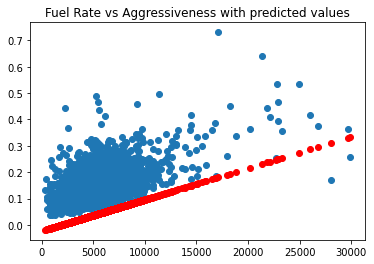

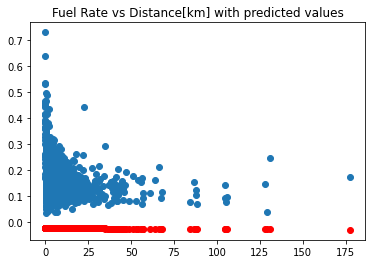

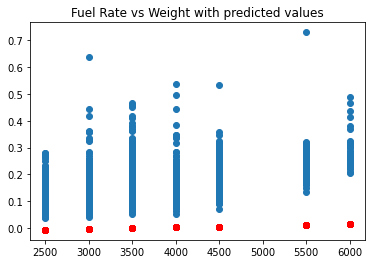

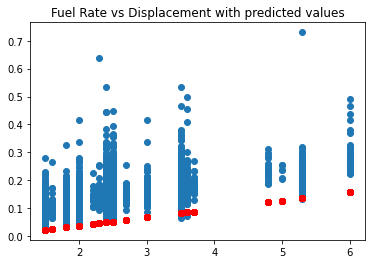

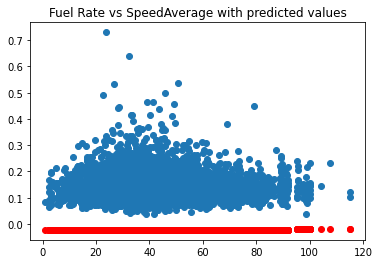

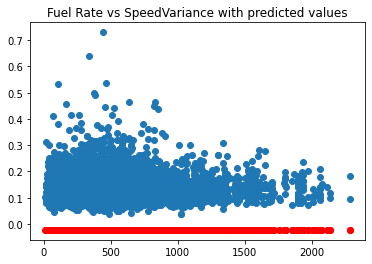

In [224]:
# single value predictions
for i, feature in enumerate(features):
    plt.scatter(X[:,i], y)
    plt.scatter(X[:,i], model.coef_[0][i]*X[:,i] + model.intercept_[0], color='red')
    plt.title(f"Fuel Rate vs {feature} with predicted values")
    plt.show()

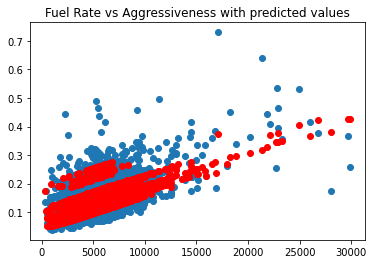

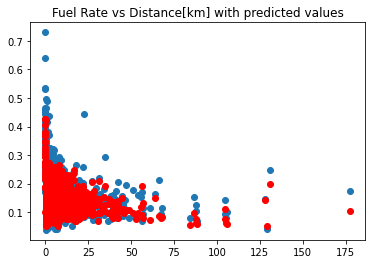

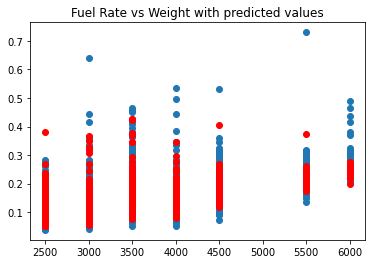

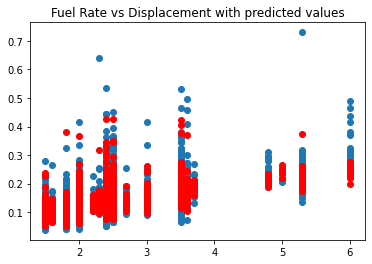

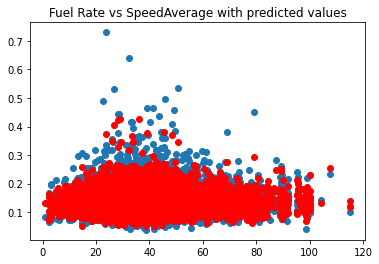

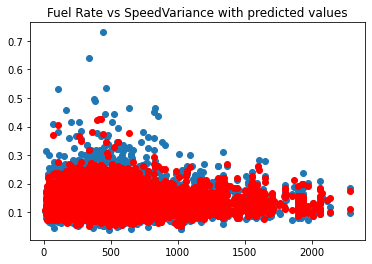

In [225]:
#plotting full model values
for i, feature in enumerate(features):
    plt.scatter(X[:,i], y)
    plt.scatter(X[:,i], preds, color='red')
    plt.title(f"Fuel Rate vs {feature} with predicted values")
    plt.show()

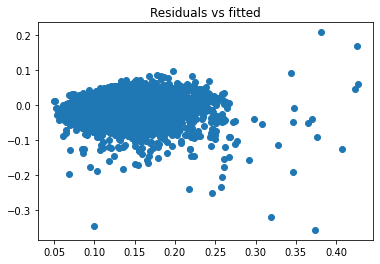

In [226]:
# lets plot our residuals:
residuals = (preds - y)
plt.scatter(preds, residuals)
plt.title('Residuals vs fitted')
plt.show()

## Adding Some Interaction Variables

In [227]:
# thats not a particuarly compelling plot -- lets add some interaction variables to our set:
for i, f in enumerate(features):
    print(f"{i} : {f}")

0 : Aggressiveness
1 : Distance[km]
2 : Weight
3 : Displacement
4 : SpeedAverage
5 : SpeedVariance


Lets iteract the following variables:

`Aggressiveness` and `SpeedAverage`

`Aggressiveness` and `Distance[km]`

`Displacement` and `1/Weight` => power to weight


In [228]:
X.shape

(11529, 6)

In [229]:
X = np.append(X, (X[:,0] * X[:,4]).reshape(-1,1), 1) #aggr and avespeed
X = np.append(X, (X[:,0] * X[:,3]).reshape(-1,1), 1) # aggr and distance
X = np.append(X, (X[:,3] / X[:,2]).reshape(-1,1), 1) # displ and 1/weight

In [230]:
X.shape

(11529, 9)

In [231]:
#lets update our feature list
interaction_features = features + ['Aggr*AveSpeed', 'Aggr*Distance', 'Displ/Weight']

In [232]:
# lets fit our model again:
model = LinearRegression().fit(X,y)

In [233]:
for feature, coef in zip(interaction_features, model.coef_[0]):
    print(f"{feature}: {coef}")

Aggressiveness: 4.109603391407518e-06
Distance[km]: 1.7205819257853772e-05
Weight: -9.172978419857352e-06
Displacement: 0.03477552361547563
SpeedAverage: -5.035984700663981e-05
SpeedVariance: 1.9055986521698432e-07
Aggr*AveSpeed: 1.2604850684488406e-08
Aggr*Distance: 2.9460774284102315e-06
Displ/Weight: -70.59826830183906


In [234]:
# lets see which value has the highest average impact on our regression:

print('Impact = MEAN * Coef')
for i, vals in enumerate(zip(interaction_features, model.coef_[0])):
    feature, coef = vals
    print(f"{feature}: {X[:,i].mean()*coef}")
    
# we can actually get the relative percentages here:
print('========= PERCENTAGES =========')

impact = np.array([np.abs(coef * X[:,i].mean()) for i, coef in enumerate(model.coef_[0])])
for feature, i in zip(interaction_features, (impact*100)/impact.sum()):
    print(f"{feature}: {i}")

Impact = MEAN * Coef
Aggressiveness: 0.021379139574695276
Distance[km]: 9.200587570222754e-05
Weight: -0.030872972082272087
Displacement: 0.08715719293232776
SpeedAverage: -0.001984499793928708
SpeedVariance: 9.780627171411371e-05
Aggr*AveSpeed: 0.00258460756699648
Aggr*Distance: 0.038407058144407265
Displ/Weight: -0.052105052045205595
========= PERCENTAGES =========
Aggressiveness: 9.10989821095411
Distance[km]: 0.03920476591345401
Weight: 13.15532985583848
Displacement: 37.138686203526134
SpeedAverage: 0.8456182747292637
SpeedVariance: 0.04167638162403438
Aggr*AveSpeed: 1.1013311255270803
Aggr*Distance: 16.365690913579872
Displ/Weight: 22.202564268307555


In [235]:
# now lets compute r^2:
# WOW WE have an almost 0 impact on r^2 -- surprising
preds = model.predict(X)
r_2 = 1 - (((y - preds)**2).sum())/((y - y.mean())**2).sum()
print(r_2)

0.6200223135986707


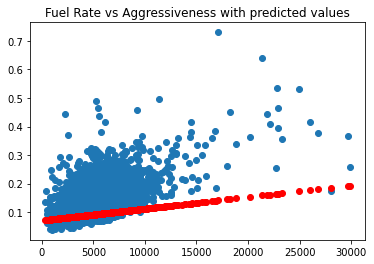

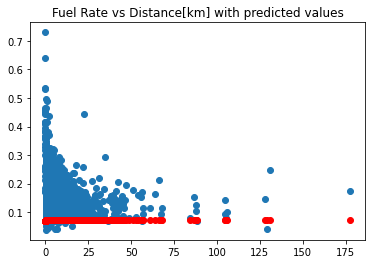

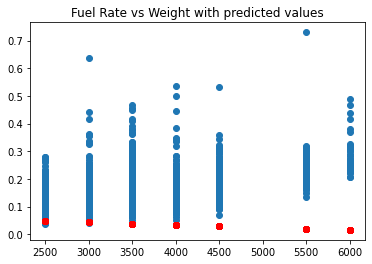

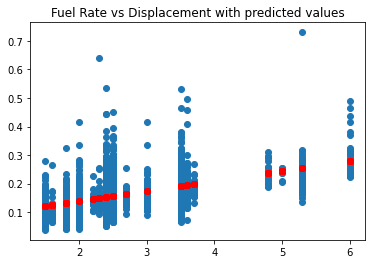

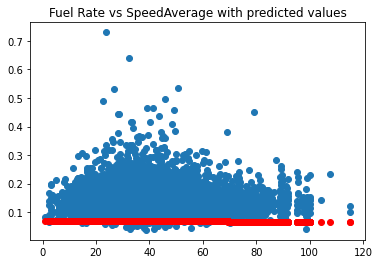

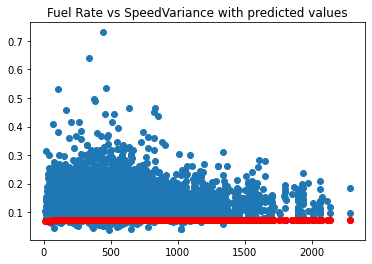

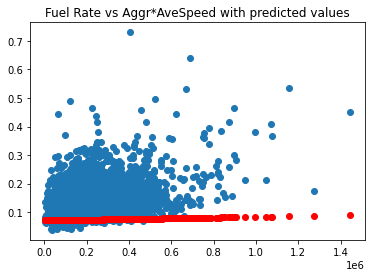

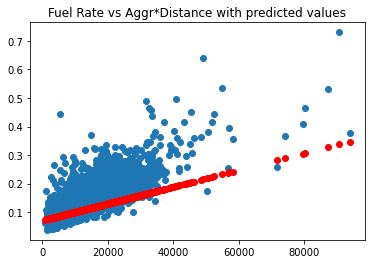

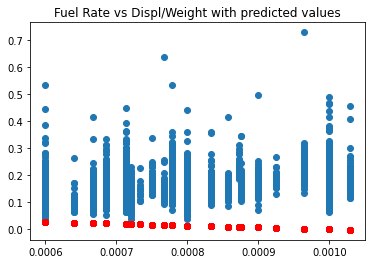

In [236]:
# single value predictions
for i, feature in enumerate(interaction_features):
    plt.scatter(X[:,i], y)
    plt.scatter(X[:,i], model.coef_[0][i]*X[:,i] + model.intercept_[0], color='red')
    plt.title(f"Fuel Rate vs {feature} with predicted values")
    plt.show()

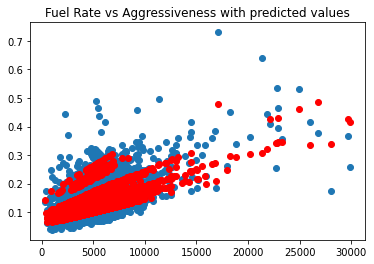

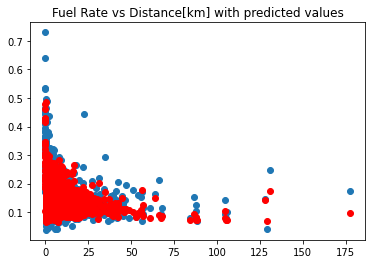

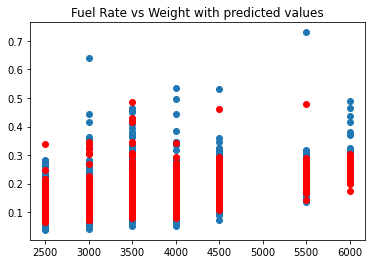

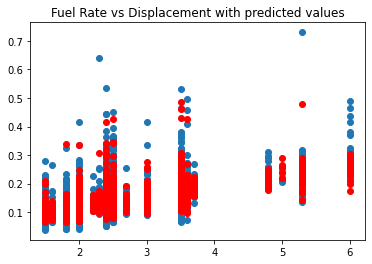

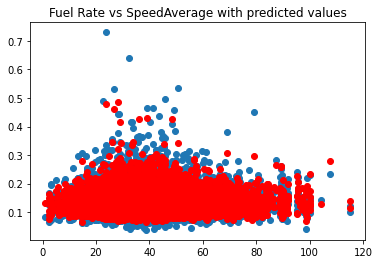

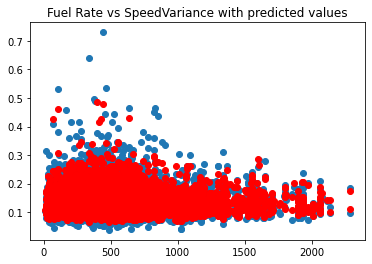

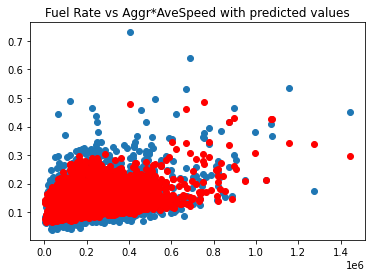

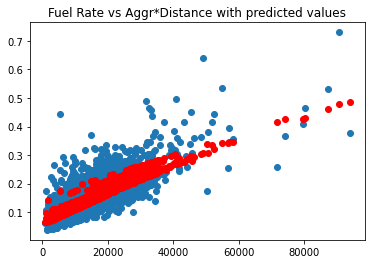

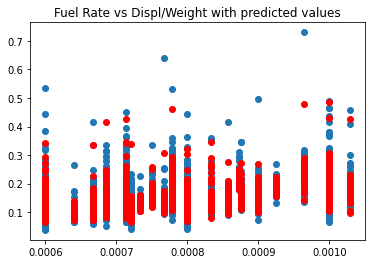

In [238]:
#plotting full model values
for i, feature in enumerate(interaction_features):
    plt.scatter(X[:,i], y)
    plt.scatter(X[:,i], preds, color='red')
    plt.title(f"Fuel Rate vs {feature} with predicted values")
    plt.show()

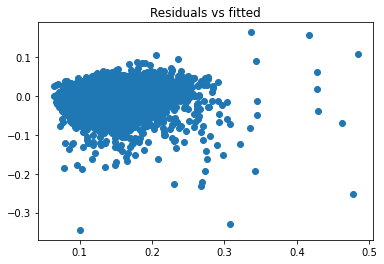

In [239]:
# resuidual vs fitted plots!
residuals = (preds - y)
plt.scatter(preds, residuals)
plt.title('Residuals vs fitted')
plt.show() # we have the same issue with this plot where our residuals vs fitted are still clumpy

## Lets run a larger interaction variable test:

In [255]:
# reset the data 
X = np.array(data.loc[:, features])
y = np.array(data.loc[:,target]).reshape(-1,1)

In [256]:
X.shape

(11529, 6)

In [257]:
y.shape

(11529, 1)

In [258]:
# lets make all the interaction variables:
all_interaction = features.copy()
for i in range(len(features)):
    for j in range(i+1, len(features)):
        X = np.append(X, (X[:, i] * X[:, j]).reshape(-1,1), 1)
        all_interaction.append(f"{features[i]}*{features[j]}")

In [259]:
all_interaction

['Aggressiveness',
 'Distance[km]',
 'Weight',
 'Displacement',
 'SpeedAverage',
 'SpeedVariance',
 'Aggressiveness*Distance[km]',
 'Aggressiveness*Weight',
 'Aggressiveness*Displacement',
 'Aggressiveness*SpeedAverage',
 'Aggressiveness*SpeedVariance',
 'Distance[km]*Weight',
 'Distance[km]*Displacement',
 'Distance[km]*SpeedAverage',
 'Distance[km]*SpeedVariance',
 'Weight*Displacement',
 'Weight*SpeedAverage',
 'Weight*SpeedVariance',
 'Displacement*SpeedAverage',
 'Displacement*SpeedVariance',
 'SpeedAverage*SpeedVariance']

In [260]:
X.shape

(11529, 21)

In [261]:
model = ().fit(X, y)

In [264]:
for feature, coef in zip(all_interaction, model.coef_[0]):
    print(f"{feature}: {coef}")

Aggressiveness: 2.5022926173706823e-06
Distance[km]: 0.0003009805061247783
Weight: -1.1893202490620523e-05
Displacement: 0.010147303150106018
SpeedAverage: 6.144613174886634e-05
SpeedVariance: 1.974361128572301e-07
Aggressiveness*Distance[km]: -3.8251066330590243e-07
Aggressiveness*Weight: 1.7675447132677472e-09
Aggressiveness*Displacement: 1.6223401111833852e-06
Aggressiveness*SpeedAverage: 1.7993876257149626e-08
Aggressiveness*SpeedVariance: -6.893053204528441e-10
Distance[km]*Weight: 3.375073559130909e-07
Distance[km]*Displacement: -0.00022565392091916604
Distance[km]*SpeedAverage: 5.175361508629751e-06
Distance[km]*SpeedVariance: -1.7215678674891726e-09
Weight*Displacement: 3.2538600924069544e-06
Weight*SpeedAverage: -1.4078378054548045e-08
Weight*SpeedVariance: 4.779569972704856e-10
Displacement*SpeedAverage: -3.919495876954216e-05
Displacement*SpeedVariance: 1.8208014369773895e-06
SpeedAverage*SpeedVariance: -4.7788005972552274e-08


In [265]:
# lets see which value has the highest average impact on our regression:

print('Impact = MEAN * Coef')
for i, vals in enumerate(zip(all_interaction, model.coef_[0])):
    feature, coef = vals
    print(f"{feature}: {X[:,i].mean()*coef}")
    
# we can actually get the relative percentages here:
print('========= PERCENTAGES =========')

impact = np.array([np.abs(coef * X[:,i].mean()) for i, coef in enumerate(model.coef_[0])])
for feature, i in zip(all_interaction, (impact*100)/impact.sum()):
    print(f"{feature}: {i}")

Impact = MEAN * Coef
Aggressiveness: 0.01301752457070437
Distance[km]: 0.0016094540236826912
Weight: -0.04002827562167602
Displacement: 0.02543198107311982
SpeedAverage: 0.002421370259072949
SpeedVariance: 0.00010133555708755586
Aggressiveness*Distance[km]: -0.009542428587891507
Aggressiveness*Weight: 0.031002679734935045
Aggressiveness*Displacement: 0.021149923073762494
Aggressiveness*SpeedAverage: 0.003689619964404585
Aggressiveness*SpeedVariance: -0.0018368910594713528
Distance[km]*Weight: 0.006168451356207922
Distance[km]*Displacement: -0.003084888067653157
Distance[km]*SpeedAverage: 0.0010893730424327756
Distance[km]*SpeedVariance: -4.766858874831378e-06
Weight*Displacement: 0.02881071700321241
Weight*SpeedAverage: -0.001866221008820074
Weight*SpeedVariance: 0.0008241984075872981
Displacement*SpeedAverage: -0.0038689221787572207
Displacement*SpeedVariance: 0.0023391801100916274
SpeedAverage*SpeedVariance: -0.0010369376461777547
========= PERCENTAGES =========
Aggressiveness: 6.543

In [266]:
# now lets compute r^2:
# WOW WE have an almost 0 impact on r^2 -- surprising
preds = model.predict(X)
r_2 = 1 - (((y - preds)**2).sum())/((y - y.mean())**2).sum()
print(r_2)

0.634915533525551


## Optimizing our Linear Regression with Smart Variable Choices

## NOTES:
- [] Model SpeedAverage as interacting with itself 

In [355]:
data = pd.read_csv('./NVFEL498/alltrips_final.csv')

In [356]:
# remeber to do our NAN check:
mask = [~(np.isnan(data.iloc[i,:]).sum()>0) for i in range(len(data))]
data = data.loc[mask]

In [357]:
data.head()

,TripId,TripId_raw,VehId,Aggressivity,Aggressiveness,Distance[km],Fuel Consumed[L],Fuel Rate[gpm],Weight,Displacement,SpeedAverage,SpeedVariance,Air Temperature[F],Precipitation Level[mm]
0,0,2265,123,475.645508,5748.696207,9.225222,0.895646,0.097087,2500.0,1.8,46.423729,147.494133,6.40,0.0
1,1,1239,135,269.540959,6372.966896,2.223611,0.441901,0.198731,3500.0,2.5,40.748170,447.766401,-6.47,0.0
2,4,2263,575,266.112770,5665.167276,6.323556,1.008958,0.159556,4000.0,2.4,32.929095,247.070941,1.52,0.0
3,7,1681,522,552.585767,5891.611649,2.743222,0.344075,0.125427,3000.0,2.4,33.915000,447.276871,8.92,0.0
4,8,1375,250,529.245807,5535.915731,4.683417,0.937469,0.200168,5500.0,5.3,33.196768,319.067811,12.23,0.0


In [360]:
# lets make our goal dataset:
features = [
    'Aggressiveness',
    'Weight',
    'Displacement',
    'Air Temperature[F]',
    'Precipitation Level[mm]',
    'SpeedAverage',
    'Aggressiveness*SpeedAverage',
    'Aggressiveness*Weight',
    'Aggressiveness*Displacement',
    'Displacement/Weight'
]

def transform_data(data, features, out = 'Fuel Rate[gpm]'):
    d = pd.DataFrame(columns = features)
    
    for f in features:
        if '*' in f:
            f1, f2 = f.split('*')
            d[f] = data[f1] * data[f2]
        elif '/' in f:
            f1, f2 = f.split('/')
            d[f] = data[f1] / data[f2]
        else:
            d[f] = data[f]
            
    return np.array(d), np.array(data[out]), {f:i for i,f in enumerate(features)}

In [361]:
X, y, features = transform_data(data, features)

In [362]:
X.shape

(11529, 9)

In [363]:
y.shape

(11529,)

In [364]:
features

{'Aggressiveness': 0,
 'Weight': 1,
 'Displacement': 2,
 'Air Temperature[F]': 3,
 'Precipitation Level[mm]': 4,
 'Aggressiveness*SpeedAverage': 5,
 'Aggressiveness*Weight': 6,
 'Aggressiveness*Displacement': 7,
 'Displacement/Weight': 8}

In [365]:
model = LinearRegression().fit(X,y)

In [366]:
# now lets compute r^2:
# WOW WE have an almost 0 impact on r^2 -- surprising
preds = model.predict(X)
r_2 = 1 - (((y - preds)**2).sum())/((y - y.mean())**2).sum()
print(r_2)

0.6209389130103071


In [367]:
model.coef_

array([ 2.13593454e-06, -1.82751878e-05,  4.20519531e-02, -5.19026334e-05,
        2.09968485e-03,  4.15326329e-09,  1.72022390e-09,  1.58478008e-06,
       -7.16486187e+01])

In [368]:
# lets see which value has the highest average impact on our regression:

print('Impact = MEAN * Coef')
for i, vals in enumerate(zip(features.keys(), model.coef_)):
    feature, coef = vals
    print(f"{feature}: {X[:,i].mean()*coef}")
    
# we can actually get the relative percentages here:
print('========= PERCENTAGES =========')

impact = np.array([np.abs(coef * X[:,i].mean()) for i, coef in enumerate(model.coef_)])
for feature, i in zip(features.keys(), (impact*100)/impact.sum()):
    print(f"{feature}: {i}")

Impact = MEAN * Coef
Aggressiveness: 0.011111642238111044
Weight: -0.06150776087665828
Displacement: 0.10539396116564756
Air Temperature[F]: -0.0003105317135234747
Precipitation Level[mm]: 6.375181557243468e-05
Aggressiveness*SpeedAverage: 0.0008516210136816603
Aggressiveness*Weight: 0.030172674199730336
Aggressiveness*Displacement: 0.02066026512861622
Displacement/Weight: -0.05288026317955675
========= PERCENTAGES =========
Aggressiveness: 3.9270348782742093
Weight: 21.73784190231891
Displacement: 37.24793802642581
Air Temperature[F]: 0.1097469522222709
Precipitation Level[mm]: 0.02253092728701962
Aggressiveness*SpeedAverage: 0.30097670102521673
Aggressiveness*Weight: 10.663513224602191
Aggressiveness*Displacement: 7.301673327475744
Displacement/Weight: 18.688744060368613


(array([ 2.,  4., 13., 35., 23., 14.,  6.,  2.,  0.,  1.]),
 array([1678.32719621, 2489.5547979 , 3300.78239959, 4112.01000128,
        4923.23760297, 5734.46520465, 6545.69280634, 7356.92040803,
        8168.14800972, 8979.37561141, 9790.60321309]),
 <BarContainer object of 10 artists>)

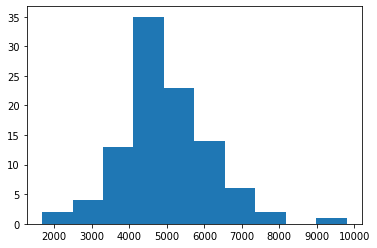

In [386]:
plt.hist(data.sort_values(by='SpeedAverage').iloc[:100]["Aggressiveness"])

(array([ 3.,  8., 16., 33., 16., 12.,  5.,  5.,  1.,  1.]),
 array([ 1256.65314207,  2289.83683409,  3323.02052612,  4356.20421814,
         5389.38791016,  6422.57160218,  7455.75529421,  8488.93898623,
         9522.12267825, 10555.30637027, 11588.4900623 ]),
 <BarContainer object of 10 artists>)

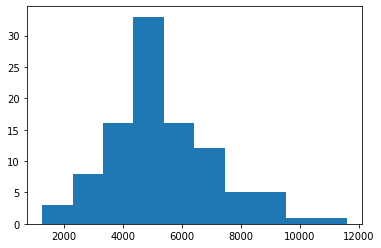

In [383]:
plt.hist(data.sort_values(by='SpeedAverage').iloc[-100:]['Aggressiveness'])

In [387]:
np.percentile(data.sort_values(by='SpeedAverage').iloc[:100]["Aggressiveness"], 10)

3532.340092084551

In [388]:
np.percentile(data.sort_values(by='SpeedAverage').iloc[-100:]['Aggressiveness'], )

3192.4462997625164

In [396]:
data.sort_values(by='SpeedAverage').iloc[-500:].iloc[:5]

,TripId,TripId_raw,VehId,Aggressivity,Aggressiveness,Distance[km],Fuel Consumed[L],Fuel Rate[gpm],Weight,Displacement,SpeedAverage,SpeedVariance,Air Temperature[F],Precipitation Level[mm]
762,1136,119,283,252.386089,3525.635051,9.179056,0.705072,0.076813,2500.0,1.5,68.930876,1162.129160,0.91,0.0
10278,15408,67,608,303.782801,5686.823085,1.249028,0.157412,0.126028,2500.0,2.0,68.942667,1223.415934,-2.68,0.0
5970,8914,2648,276,314.366184,1768.410051,2.551444,0.182009,0.071336,2500.0,2.0,68.954373,659.997910,4.83,0.0
2377,3539,2648,285,331.641973,5136.879464,3.130694,0.331249,0.105807,3000.0,2.4,68.954373,659.997910,4.83,0.0
5977,8927,1506,276,414.785092,2060.050692,2.564500,0.207090,0.080753,2500.0,2.0,68.954839,196.497947,-11.64,0.0


In [404]:
len(data)

11529

In [407]:
for i in range(20):
    slow = np.percentile(data.sort_values(by='SpeedAverage').iloc[:100]["Aggressiveness"], i*5)
    fast = np.percentile(data.sort_values(by='SpeedAverage').iloc[-100:]['Aggressiveness'], i*5)
    whole = np.percentile(data['Aggressiveness'],i*5)
#     print(f"percentile: {i*10} slow: {slow } fast: {fast} delta: {np.abs(slow-fast)}")
#     print(f"percentile: {i*5} slow: {slow } fast: {fast} whole: {whole}")
#     print(f"percentile:{i*5} slow: {slow} whole: {whole} delta: {(slow-whole)}")
#     print(f"percentile:{i*5} fast: {fast} whole: {whole} delta: {(fast-whole)}")
    print(f"delta sum: {(slow-whole) - (fast-whole)}")

delta sum: 421.67405414038114
delta sum: 439.60456237929156
delta sum: 339.89379232203464
delta sum: 298.22281575765464
delta sum: 123.52070885364992
delta sum: 52.93083914992167
delta sum: -20.723128990458463
delta sum: -54.35919720849688
delta sum: -122.07760061916179
delta sum: -336.00532952500726
delta sum: -337.2220608087837
delta sum: -323.8936532300577
delta sum: -256.3493185157058
delta sum: -324.1962381910653
delta sum: -401.31986135311126
delta sum: -692.5668291800912
delta sum: -585.8897767897624
delta sum: -1047.223507414741
delta sum: -1353.6031307795065
delta sum: -1778.316556743308


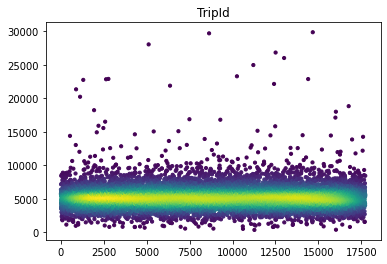

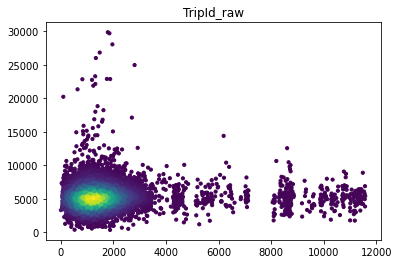

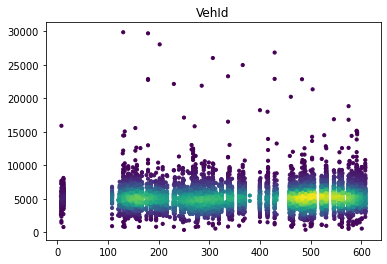

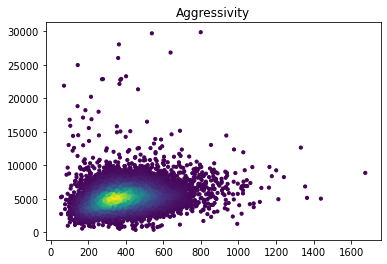

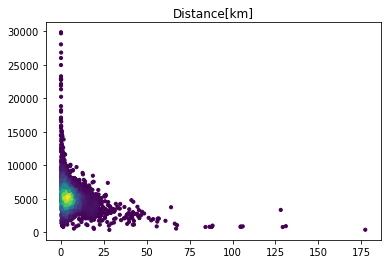

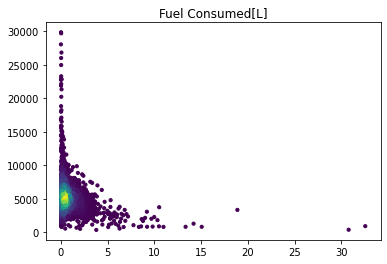

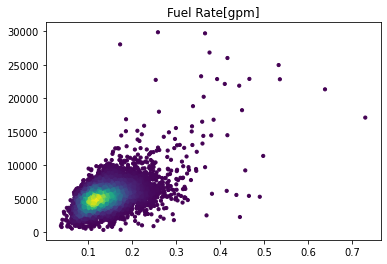

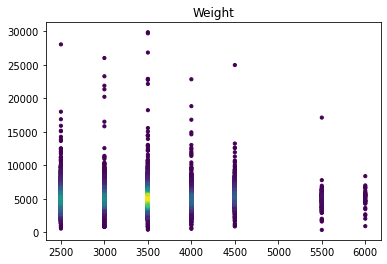

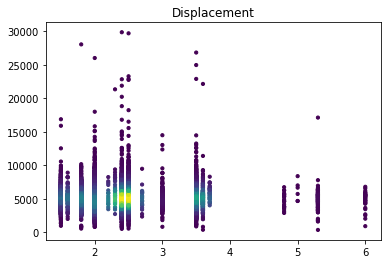

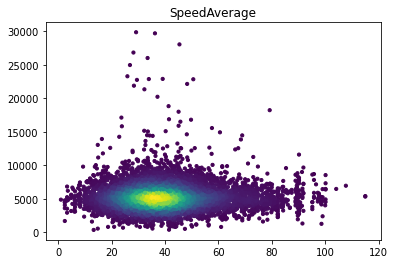

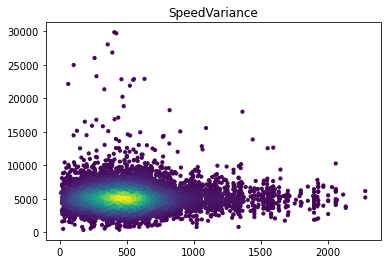

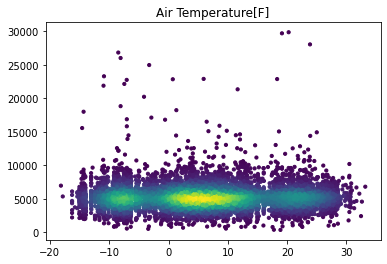

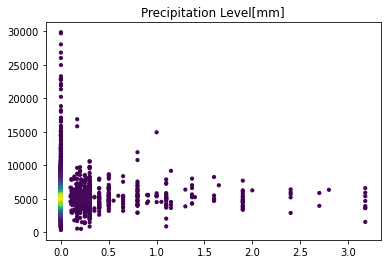

In [417]:
from scipy.stats import gaussian_kde

for col in data.columns:
#     plt.scatter(data[col], data['Aggressiveness'], s=1)

    # Calculate the point density
    if col != 'Aggressiveness':
        xy = np.vstack([data[col],data['Aggressiveness']])
        z = gaussian_kde(xy)(xy)
        fig, ax = plt.subplots()
        ax.scatter(data[col], data['Aggressiveness'], c=z, s=10)
        plt.title(col)
        plt.show()

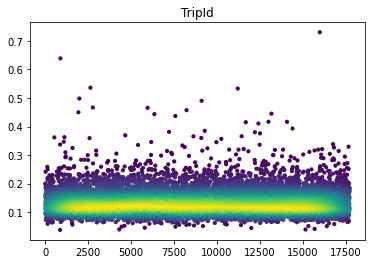

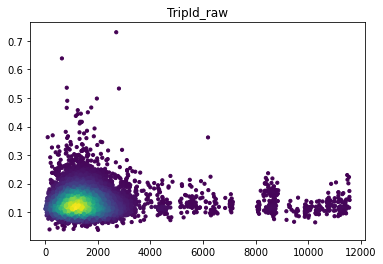

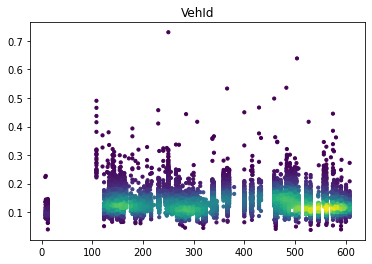

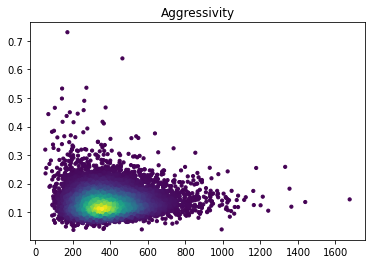

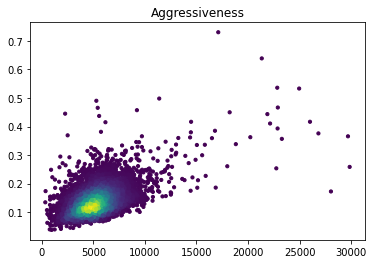

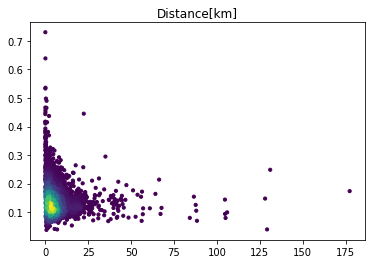

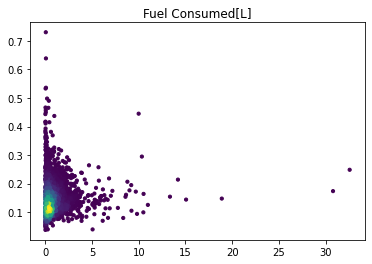

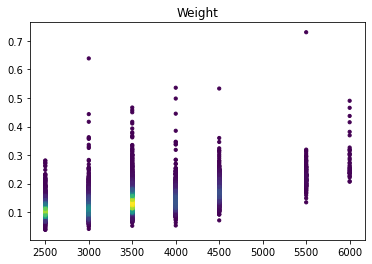

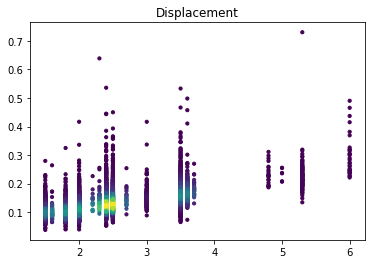

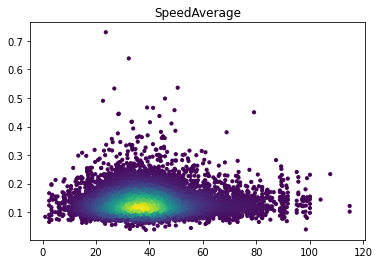

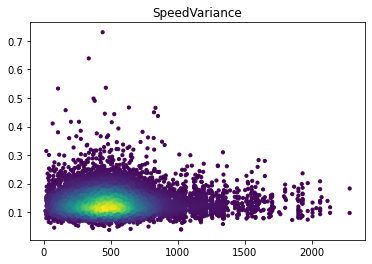

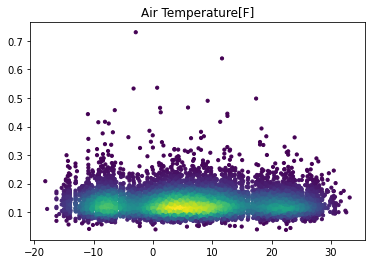

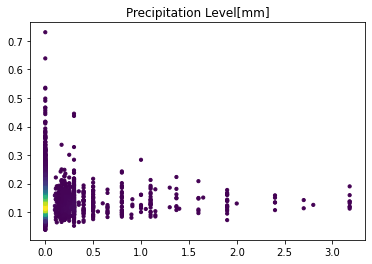

In [429]:
from scipy.stats import gaussian_kde

for col in data.columns:
#     plt.scatter(data[col], data['Aggressiveness'], s=1)

    # Calculate the point density
    if col != 'Fuel Rate[gpm]':
        xy = np.vstack([data[col],data['Fuel Rate[gpm]']])
        z = gaussian_kde(xy)(xy)
        fig, ax = plt.subplots()
        ax.scatter(data[col], data['Fuel Rate[gpm]'], c=z, s=10)
        plt.title(col)
        plt.show()

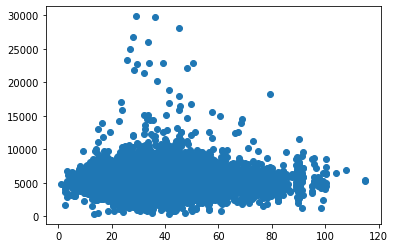

In [371]:
plt.scatter(data['SpeedAverage'], data['Aggressiveness'])

In [369]:
mins = sorted(X[:,0])[:5]
maxs = sorted(X[:,0], reverse=True)[:5]

In [328]:
mins

[347.0142102775127,
 373.8735119362273,
 504.23387009804975,
 543.8423645320197,
 545.6738106049892]

In [329]:
maxs

[29848.90022314313,
 29686.03733894293,
 28035.17411185368,
 26820.738938725863,
 26003.61010830325]

In [337]:
model.predict(X[np.argsort(X[:,0])][-5:]) - y[np.argsort(X[:,0])][-5:]

array([-0.07496243,  0.0875558 ,  0.15634593,  0.07052118,  0.17305058])

In [ ]:
def min_max_resids(data, features, n=5):
    for k,v in features.items():
        plt.title(k)
        resids = model.predict(X[np.argsort(X[:,v])]) - y[np.argsort(X[:,v])]
        mins = resids[:n]
        maxs = resids[-n:]
        plt.scatter()

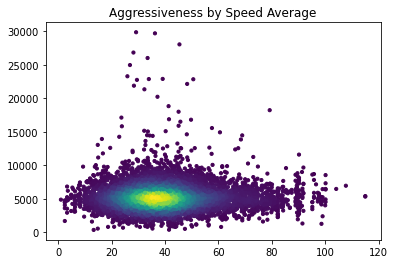

In [431]:
xy = np.vstack([data['SpeedAverage'],data['Aggressiveness']])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
ax.scatter(data['SpeedAverage'],data['Aggressiveness'], c=z, s=10)
plt.title('Aggressiveness by Speed Average')
plt.show()

In [422]:
data['Air Temperature[F]'].max()

33.17

In [423]:
data['Air Temperature[F]']*9/5 + 32

0        43.520
1        20.354
2        34.736
3        48.056
4        54.014
          ...  
11797    54.014
11798    67.172
11800    62.024
11801    72.482
11802    16.754
Name: Air Temperature[F], Length: 11529, dtype: float64